In [65]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import product

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_16280/2238247347.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_16280/2238247347.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [66]:
def predict_mean_reversion_label(spread, window, threshold):
    labels = []
    mean = spread.mean()

    for i in range(len(spread)):
        future_spread = spread[i + 1 : i + 1 + window]
        if len(future_spread) < window:
            labels.append(np.nan)
        elif any(abs(j - mean) < threshold for j in future_spread):
            labels.append(1)
        else:
            labels.append(0)

    return pd.Series(labels, index = spread.index)

In [67]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

optimal_window_threshold = {'IEMG_EEM': {'window': 7, 'threshold': 0.03},
                            'ARKK_ARKW': {'window': 10, 'threshold': 0.03},
                            'TLT_SPTL': {'window': 10, 'threshold': 0.03},
                            'SHY_VGSH': {'window': 7, 'threshold': 0.03},
                            'SOXX_ITA': {'window': 30, 'threshold': 0.1}
}

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = optimal_window_threshold[pair_name]['window']

    threshold = optimal_window_threshold[pair_name]['threshold']

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, window = window, threshold = threshold)
    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, window = window, threshold = threshold)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [68]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [69]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size, dropout = 0.0):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        dropout = dropout if num_layers > 1 else 0.0
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        # out = self.sigmoid(out)
        return out.squeeze()

In [70]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [71]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    optimal_thresholds = {'IEMG_EEM': 0.90,
                          'ARKK_ARKW': 0.50,
                          'TLT_SPTL': 0.50,
                          'SHY_VGSH': 0.80,
                          'SOXX_ITA': 0.3
                          }
    
    threshold = optimal_thresholds[pair_name]

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [72]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [73]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [74]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [75]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device='cpu'):
    
    params = {'IEMG_EEM': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 1, 'window_size': 3, 'batch_size': 32, 'dropout': 0.0},
              'ARKK_ARKW': {'hidden_size': 70, 'lr': 0.0001, 'num_layers': 2, 'window_size': 5, 'batch_size': 128, 'dropout': 0.0},
              'TLT_SPTL': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0},
              'SHY_VGSH': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.2},
              'SOXX_ITA': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 1, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0}
              }
    
    hidden_size = params[pair_name]['hidden_size']
    lr = params[pair_name]['lr']
    num_layers = params[pair_name]['num_layers']
    window_size = params[pair_name]['window_size']
    batch_size = params[pair_name]['batch_size']
    dropout = params[pair_name]['dropout']

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred

In [76]:
# grid search

def grid_search(pair_name, params, device = 'cpu'):
    window_size = params['window_size']
    epochs = params['epochs']
    hidden_size = params['hidden_size']
    lr = params['learning_rate']
    num_layers = params['num_layers']
    batch_size = params['batch_size']
    dropout = params['dropout']

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)

    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)

    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    f1 = f1_score(y_true, y_pred_label)

    return f1, model, params

In [77]:
def grid_search_for_pair(pair_name, param_grid, device='cpu'):
    keys, values = zip(*param_grid.items())
    best_f1 = -np.inf
    best_params = None
    best_model = None

    for v in product(*values):
        params = dict(zip(keys, v))
        print(f"Testing params: {params}")
        f1, model, _ = grid_search(pair_name, params, device=device)
        print(f"F1 Score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_model = model

    print(f"Best params for {pair_name}: {best_params}")
    print(f"Best F1 score: {best_f1:.4f}")
    return best_model, best_params, best_f1


Training model for pair: IEMG_EEM
Epoch 1/50 - Loss: 0.1535
Epoch 2/50 - Loss: 0.1432
Epoch 3/50 - Loss: 0.1324
Epoch 4/50 - Loss: 0.1203
Epoch 5/50 - Loss: 0.1094
Epoch 6/50 - Loss: 0.1015
Epoch 7/50 - Loss: 0.0963
Epoch 8/50 - Loss: 0.0930
Epoch 9/50 - Loss: 0.0908
Epoch 10/50 - Loss: 0.0892
Epoch 11/50 - Loss: 0.0880
Epoch 12/50 - Loss: 0.0870
Epoch 13/50 - Loss: 0.0862
Epoch 14/50 - Loss: 0.0855
Epoch 15/50 - Loss: 0.0848
Epoch 16/50 - Loss: 0.0843
Epoch 17/50 - Loss: 0.0837
Epoch 18/50 - Loss: 0.0832
Epoch 19/50 - Loss: 0.0827
Epoch 20/50 - Loss: 0.0822
Epoch 21/50 - Loss: 0.0817
Epoch 22/50 - Loss: 0.0812
Epoch 23/50 - Loss: 0.0808
Epoch 24/50 - Loss: 0.0803
Epoch 25/50 - Loss: 0.0798
Epoch 26/50 - Loss: 0.0794
Epoch 27/50 - Loss: 0.0789
Epoch 28/50 - Loss: 0.0784
Epoch 29/50 - Loss: 0.0779
Epoch 30/50 - Loss: 0.0774
Epoch 31/50 - Loss: 0.0769
Epoch 32/50 - Loss: 0.0764
Epoch 33/50 - Loss: 0.0759
Epoch 34/50 - Loss: 0.0755
Epoch 35/50 - Loss: 0.0750
Epoch 36/50 - Loss: 0.0745
Ep

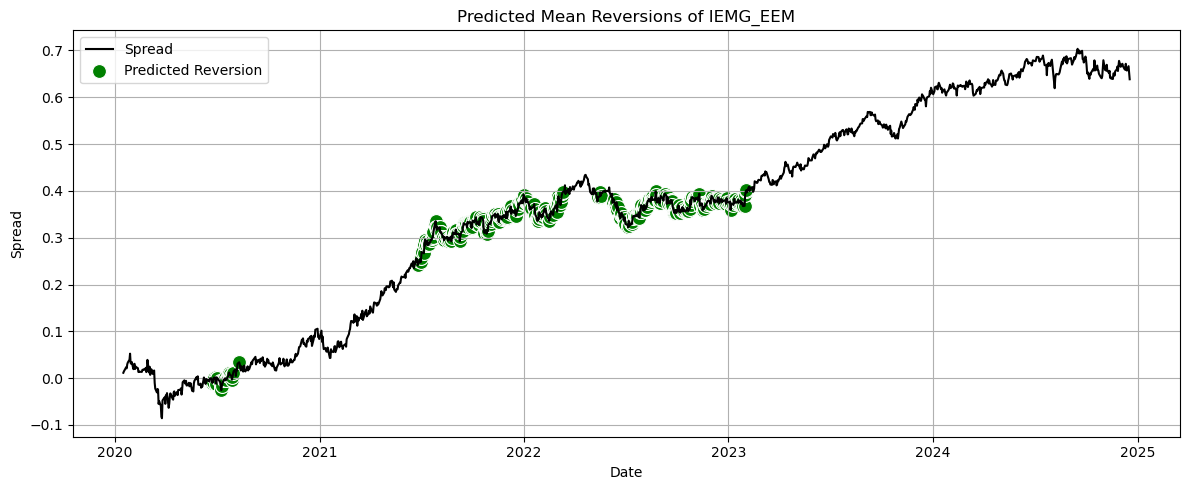

Confusion Matrix:
[[850  78]
 [ 20 292]]
F1 Score: 0.8563

Training model for pair: ARKK_ARKW
Epoch 1/50 - Loss: 0.5952
Epoch 2/50 - Loss: 0.5945
Epoch 3/50 - Loss: 0.5941
Epoch 4/50 - Loss: 0.5938
Epoch 5/50 - Loss: 0.5934
Epoch 6/50 - Loss: 0.5930
Epoch 7/50 - Loss: 0.5926
Epoch 8/50 - Loss: 0.5922
Epoch 9/50 - Loss: 0.5917
Epoch 10/50 - Loss: 0.5913
Epoch 11/50 - Loss: 0.5908
Epoch 12/50 - Loss: 0.5903
Epoch 13/50 - Loss: 0.5898
Epoch 14/50 - Loss: 0.5892
Epoch 15/50 - Loss: 0.5887
Epoch 16/50 - Loss: 0.5881
Epoch 17/50 - Loss: 0.5874
Epoch 18/50 - Loss: 0.5868
Epoch 19/50 - Loss: 0.5860
Epoch 20/50 - Loss: 0.5853
Epoch 21/50 - Loss: 0.5845
Epoch 22/50 - Loss: 0.5836
Epoch 23/50 - Loss: 0.5827
Epoch 24/50 - Loss: 0.5817
Epoch 25/50 - Loss: 0.5807
Epoch 26/50 - Loss: 0.5796
Epoch 27/50 - Loss: 0.5784
Epoch 28/50 - Loss: 0.5772
Epoch 29/50 - Loss: 0.5758
Epoch 30/50 - Loss: 0.5744
Epoch 31/50 - Loss: 0.5729
Epoch 32/50 - Loss: 0.5713
Epoch 33/50 - Loss: 0.5696
Epoch 34/50 - Loss: 0.56

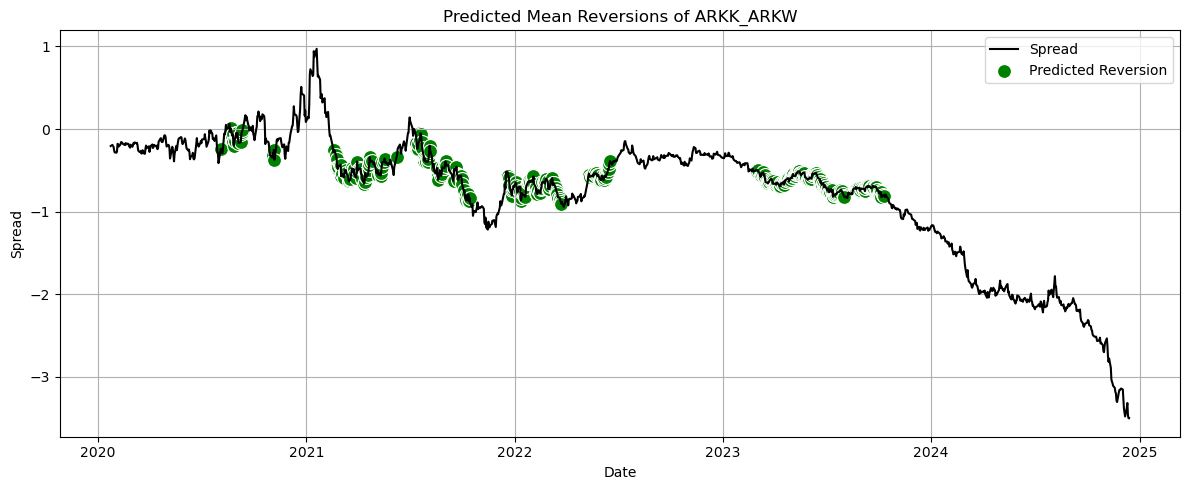

Confusion Matrix:
[[818 248]
 [ 58 108]]
F1 Score: 0.4138

Training model for pair: TLT_SPTL
Epoch 1/50 - Loss: 0.0289
Epoch 2/50 - Loss: 0.0267
Epoch 3/50 - Loss: 0.0230
Epoch 4/50 - Loss: 0.0203
Epoch 5/50 - Loss: 0.0183
Epoch 6/50 - Loss: 0.0168
Epoch 7/50 - Loss: 0.0161
Epoch 8/50 - Loss: 0.0156
Epoch 9/50 - Loss: 0.0150
Epoch 10/50 - Loss: 0.0145
Epoch 11/50 - Loss: 0.0138
Epoch 12/50 - Loss: 0.0133
Epoch 13/50 - Loss: 0.0125
Epoch 14/50 - Loss: 0.0123
Epoch 15/50 - Loss: 0.0113
Epoch 16/50 - Loss: 0.0122
Epoch 17/50 - Loss: 0.0105
Epoch 18/50 - Loss: 0.0116
Epoch 19/50 - Loss: 0.0102
Epoch 20/50 - Loss: 0.0104
Epoch 21/50 - Loss: 0.0096
Epoch 22/50 - Loss: 0.0116
Epoch 23/50 - Loss: 0.0106
Epoch 24/50 - Loss: 0.0089
Epoch 25/50 - Loss: 0.0090
Epoch 26/50 - Loss: 0.0091
Epoch 27/50 - Loss: 0.0091
Epoch 28/50 - Loss: 0.0079
Epoch 29/50 - Loss: 0.0093
Epoch 30/50 - Loss: 0.0077
Epoch 31/50 - Loss: 0.0083
Epoch 32/50 - Loss: 0.0090
Epoch 33/50 - Loss: 0.0097
Epoch 34/50 - Loss: 0.007

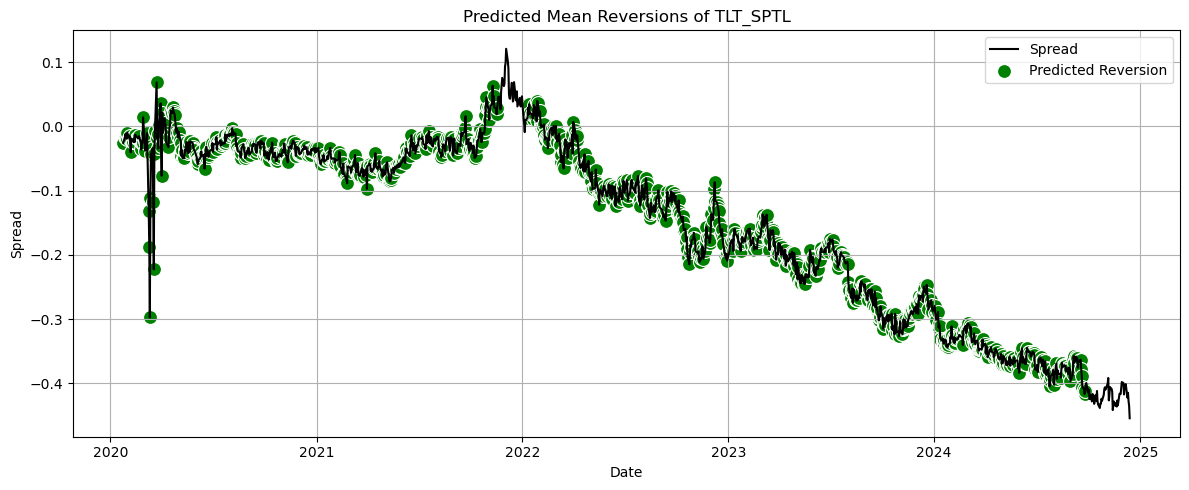

Confusion Matrix:
[[ 91 930]
 [  0 211]]
F1 Score: 0.3121

Training model for pair: SHY_VGSH
Epoch 1/50 - Loss: 0.0675
Epoch 2/50 - Loss: 0.0592
Epoch 3/50 - Loss: 0.0486
Epoch 4/50 - Loss: 0.0434
Epoch 5/50 - Loss: 0.0424
Epoch 6/50 - Loss: 0.0411
Epoch 7/50 - Loss: 0.0391
Epoch 8/50 - Loss: 0.0381
Epoch 9/50 - Loss: 0.0372
Epoch 10/50 - Loss: 0.0385
Epoch 11/50 - Loss: 0.0395
Epoch 12/50 - Loss: 0.0371
Epoch 13/50 - Loss: 0.0359
Epoch 14/50 - Loss: 0.0353
Epoch 15/50 - Loss: 0.0348
Epoch 16/50 - Loss: 0.0344
Epoch 17/50 - Loss: 0.0347
Epoch 18/50 - Loss: 0.0350
Epoch 19/50 - Loss: 0.0352
Epoch 20/50 - Loss: 0.0345
Epoch 21/50 - Loss: 0.0384
Epoch 22/50 - Loss: 0.0400
Epoch 23/50 - Loss: 0.0377
Epoch 24/50 - Loss: 0.0358
Epoch 25/50 - Loss: 0.0347
Epoch 26/50 - Loss: 0.0340
Epoch 27/50 - Loss: 0.0335
Epoch 28/50 - Loss: 0.0329
Epoch 29/50 - Loss: 0.0326
Epoch 30/50 - Loss: 0.0324
Epoch 31/50 - Loss: 0.0323
Epoch 32/50 - Loss: 0.0320
Epoch 33/50 - Loss: 0.0320
Epoch 34/50 - Loss: 0.031

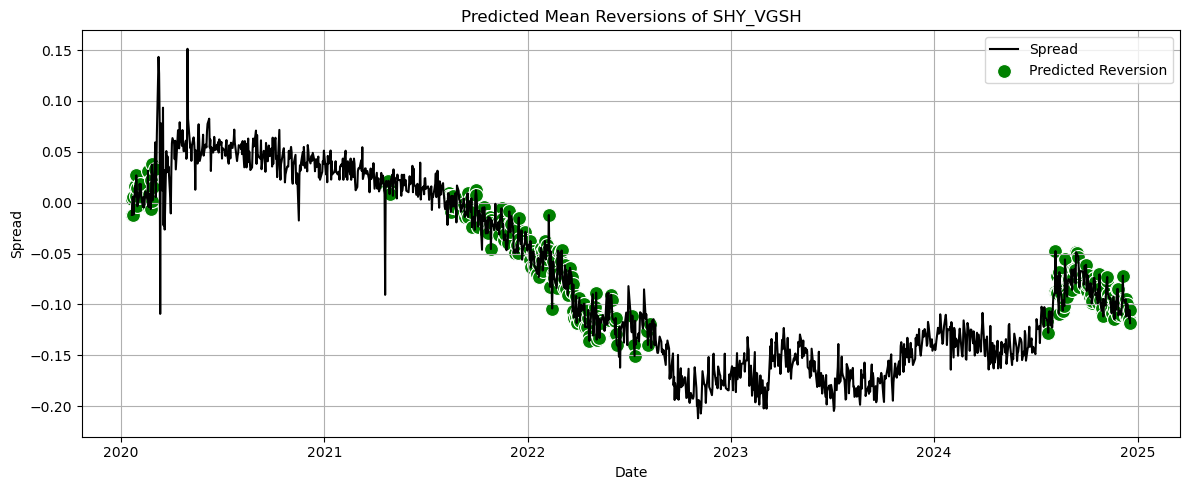

Confusion Matrix:
[[890  81]
 [ 56 211]]
F1 Score: 0.7549

Training model for pair: SOXX_ITA
Epoch 1/50 - Loss: 0.1113
Epoch 2/50 - Loss: 0.1025
Epoch 3/50 - Loss: 0.0987
Epoch 4/50 - Loss: 0.0951
Epoch 5/50 - Loss: 0.0913
Epoch 6/50 - Loss: 0.0871
Epoch 7/50 - Loss: 0.0826
Epoch 8/50 - Loss: 0.0779
Epoch 9/50 - Loss: 0.0734
Epoch 10/50 - Loss: 0.0690
Epoch 11/50 - Loss: 0.0647
Epoch 12/50 - Loss: 0.0604
Epoch 13/50 - Loss: 0.0564
Epoch 14/50 - Loss: 0.0530
Epoch 15/50 - Loss: 0.0502
Epoch 16/50 - Loss: 0.0481
Epoch 17/50 - Loss: 0.0466
Epoch 18/50 - Loss: 0.0454
Epoch 19/50 - Loss: 0.0445
Epoch 20/50 - Loss: 0.0437
Epoch 21/50 - Loss: 0.0431
Epoch 22/50 - Loss: 0.0426
Epoch 23/50 - Loss: 0.0421
Epoch 24/50 - Loss: 0.0416
Epoch 25/50 - Loss: 0.0412
Epoch 26/50 - Loss: 0.0408
Epoch 27/50 - Loss: 0.0404
Epoch 28/50 - Loss: 0.0401
Epoch 29/50 - Loss: 0.0397
Epoch 30/50 - Loss: 0.0394
Epoch 31/50 - Loss: 0.0391
Epoch 32/50 - Loss: 0.0388
Epoch 33/50 - Loss: 0.0385
Epoch 34/50 - Loss: 0.038

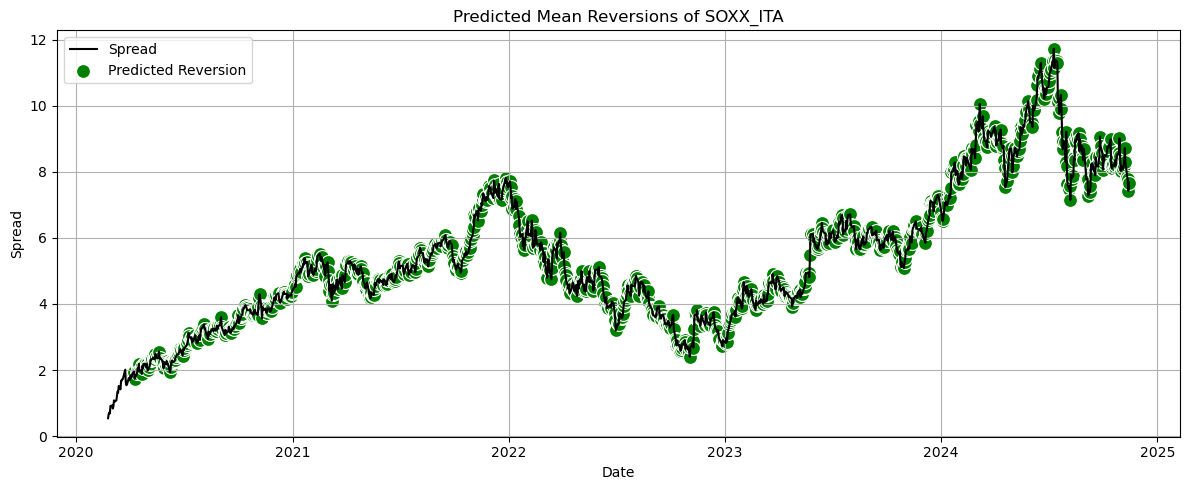

Confusion Matrix:
[[ 30 885]
 [  0 277]]
F1 Score: 0.3850
{'IEMG_EEM': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1240, 1), dtype=float32), 'y_pred': array([0.37109596, 0.3711129 , 0.35281026, ..., 0.20169908, 0.20470868,
       0.20548183], shape=(1240,), dtype=float32)}, 'ARKK_ARKW': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1232, 1), dtype=float32), 'y_pred': array([0.43961862, 0.44251984, 0.44568732, ..., 0.15549167, 0.15469155,
       0.154131  ], shape=(1232,), dtype=float32)}, 'TLT_SPTL': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)


In [78]:
results = {}

# param_grid = {
#     'hidden_size': [30, 70],
#     'learning_rate': [0.001, 0.0005, 0.0001],
#     'window_size': [3, 5, 7],
#     'epochs': [50],
#     'num_layers': [1, 2],
#     'batch_size': [32, 64, 128],
#     'dropout': [0.0, 0.2]
# }

# best_params_all = {}
# best_f1_all = {}

# for pair_name in training_spreads_df.columns:
#     print(f"\nStarting grid search for {pair_name}")
#     model, params, f1 = grid_search_for_pair(pair_name, param_grid, device='cpu')
#     results[pair_name] = {'model': model}
#     best_params_all[pair_name] = params
#     best_f1_all[pair_name] = f1

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 50,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

    # window_sizes = [3, 5, 7, 10]
    # thresholds = [0.001, 0.003, 0.005, 0.01, 0.02, 0.03]

    # for window in window_sizes:
    #     for thresh in thresholds:
    #         labels = predict_mean_reversion_label(training_spreads_df[pair_name], window, thresh)
    #         print(f"{pair_name} | Window: {window}, Thresh: {thresh} -> 1s: {labels.sum()}, 0s: {(labels==0).sum()}")

print(results)

In [79]:
def simulate_lstm_portfolio(X_df, probs, y_pred_label, initial_cash = 100, holding_period = 5, entry_threshold = 1.5, prob_threshold = 0.5):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    # df['prediction'] = y_pred_label

    df['probability'] = probs
    df['position'] = 0
    
    cash = initial_cash
    equity_curve = []
    equity_dates = []

    trade_count = 0
    trade_pnls = []
    trade_dates = []
    notional = 50

    for i in range(len(df) - holding_period):
        current_row = df.iloc[i]
        date = df.index[i]

        prob = current_row['probability']

        # current_row['prediction'] == 1

        if prob > prob_threshold and abs(current_row['z-score']) > entry_threshold:
            entry_spread = current_row['spread']
            exit_spread = df.iloc[i + holding_period]['spread']
            
            if current_row['z-score'] > 0:
                pnl = (entry_spread - exit_spread) * notional * prob
            else:
                pnl = (exit_spread - entry_spread) * notional * prob

            cash += pnl
            trade_count += 1
            trade_pnls.append(pnl)
            trade_dates.append(date)

        equity_curve.append(cash)
        equity_dates.append(date)

    equity_series = pd.Series(equity_curve, index = equity_dates)
    yearly_values = equity_series.resample('YE').last()

    stats = {
        'final_cash': cash,
        'total_trades': trade_count,
        'trade_pnls': trade_pnls,
        'trade_dates': trade_dates,
        'equity_series': equity_series,
        'yearly_values': yearly_values
    }

    return stats

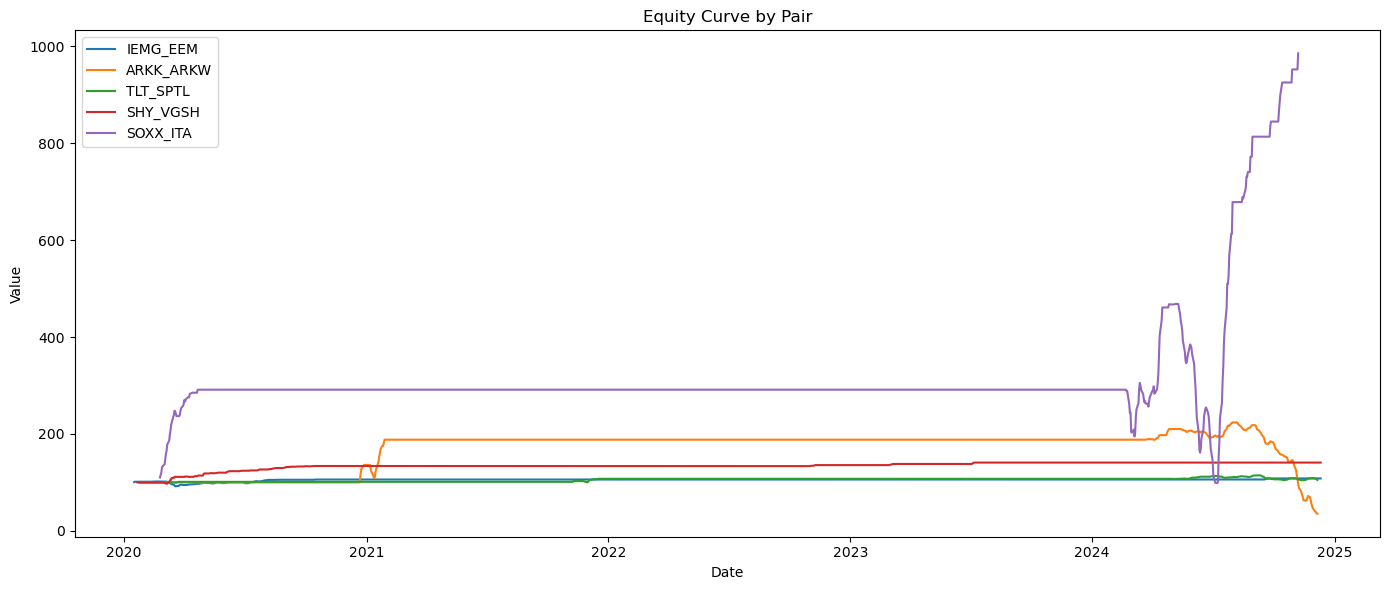


Final Portfolio Value: $1,375.29

Trade Summary: 
  IEMG_EEM: 126 trades | Total PnL: $8.22 | Avg PnL: $0.07
  ARKK_ARKW: 168 trades | Total PnL: $-64.56 | Avg PnL: $-0.38
  TLT_SPTL: 146 trades | Total PnL: $4.92 | Avg PnL: $0.03
  SHY_VGSH: 64 trades | Total PnL: $40.96 | Avg PnL: $0.64
  SOXX_ITA: 141 trades | Total PnL: $885.76 | Avg PnL: $6.28

Year-End Portfolio Values:
2020-12-31    768.620523
2021-12-31    827.052482
2022-12-31    828.925260
2023-12-31    834.129282
2024-12-31    249.173755
Freq: YE-DEC, dtype: float64


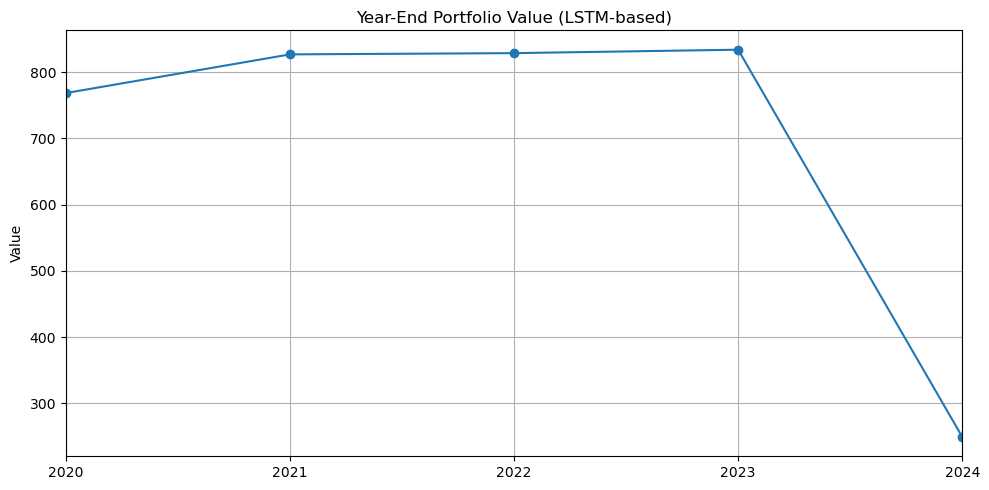

In [80]:
total_cash = 0
pair_trade_counts = defaultdict(int)
pair_pnls = defaultdict(list)
combined_equity = pd.Series(dtype = float)

plt.figure(figsize = (14, 6))

optimal_thresholds = {'IEMG_EEM': 0.90,
                      'ARKK_ARKW': 0.50,
                      'TLT_SPTL': 0.50,
                      'SHY_VGSH': 0.80,
                      'SOXX_ITA': 0.3
                      }
    
for pair_name in training_spreads_df.columns:
    model_info = results[pair_name]
    model = model_info['model']
    y_true = model_info['y_true']
    y_pred = model_info['y_pred']

    threshold = optimal_thresholds[pair_name]

    y_pred_label = (torch.sigmoid(torch.tensor(y_pred)) > threshold).int().numpy()

    probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().cpu().numpy()

    X_test_df = X_test_dict[pair_name].copy()
    stats = simulate_lstm_portfolio(X_test_df, probs, y_pred_label)

    total_cash += stats['final_cash']
    pair_trade_counts[pair_name] = stats['total_trades']
    pair_pnls[pair_name] = stats['trade_pnls']

    combined_equity = combined_equity.add(stats['equity_series'], fill_value = 0)

    plt.plot(stats['equity_series'], label = pair_name)

plt.title("Equity Curve by Pair")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
print(f"\nTrade Summary: ")
for pair, count in pair_trade_counts.items():
    total_pnl = sum(pair_pnls[pair])
    avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
    print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

yearly = combined_equity.resample('YE').last()
print("\nYear-End Portfolio Values:")
print(yearly)

plt.figure(figsize=(10, 5))
yearly.plot(marker='o')
plt.title("Year-End Portfolio Value (LSTM-based)")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()